In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from astropy.io import fits

from fitfuncs import *
from scipy.optimize import leastsq
from numpy import asarray as ar,exp
from astropy.convolution import Gaussian1DKernel, convolve

# %matplotlib notebook

In [2]:
fits_filename = ('/Users/orion/phd_research/3C297/0final_3C297_medsub.fits')     
hdul = fits.open(fits_filename)
hdul.info()
data_cube = hdul[0].data
cube_header = hdul[0].header 

print (np.shape(data_cube))
print (len(data_cube))

Filename: /Users/orion/phd_research/3C297/0final_3C297_medsub.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     779   (66, 68, 2210)   float32   
(2210, 68, 66)
2210


In [3]:
cw = cube_header['CRVAL3']
mp = cube_header['CDELT3']


# AGN 1: (x=34 to 35, y=34 to 33)
# AGN 2: (31 to 33, 36 to 34) & (31,32) (31,33) (32,33)

y1 = np.zeros(len(data_cube), dtype=float)
y2 = np.zeros(len(data_cube), dtype=float)

# [:,i,j]   i == yaxis, j = xaxis

for j in range(34,36):
    for i in range(33,35):
        print (j,i)
        y1 += data_cube[:,i,j]

for j in range(31,34):
    for i in range(34,37):
        print (j,i)
        y2 += data_cube[:,i,j]

y2 += data_cube[:,31,32]+data_cube[:,31,33]+data_cube[:,32,33]

x = np.arange(len(data_cube))
start_w = cw - cube_header['CRPIX3']*mp 
x = start_w + x*mp


34 33
34 34
35 33
35 34
31 34
31 35
31 36
32 34
32 35
32 36
33 34
33 35
33 36


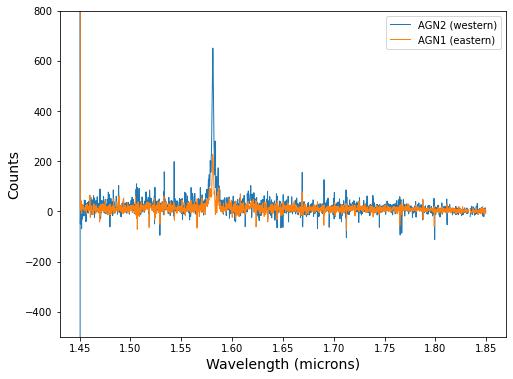

In [4]:
plt.rcParams["figure.figsize"] = [8,6]
plt.plot(x,y2,linewidth=1.0,label='AGN2 (western)')
plt.plot(x,y1,linewidth=1.0,label='AGN1 (eastern)')
#plt.xlim(1.5,1.8)
plt.ylim(-500,800)
plt.xlabel('Wavelength (microns)', {'fontsize': 14})
plt.ylabel('Counts', {'fontsize': 14})
plt.legend()


In [5]:
y1[np.isnan(y1)] = 1e-15
#y1[y1>5000] = 1e-15
y1[y1<-100] = 1e-15
y2[np.isnan(y2)] = 1e-15
#y2[y2>5000] = 1e-15
y2[y2<-100] = 1e-15

In [6]:
z = 1.40915   #spectroscopic
k = 1+z
wave = (x/k)*10000 
print (wave)


[5954.48592064 5955.29533475 5956.10474886 ... 7740.86286343 7741.67227754
 7742.48169165]


In [7]:
filename1 = ('/Users/orion/phd_research/3C297/line_fitting/error_cubes/agn1_error_cube.fits')
hdul1 = fits.open(filename1)
ec1 = hdul1[0].data

stderror1 = ec1[:,34,33]
select1 = (wave>6450) & (wave<6800)
error_spec1 = stderror1[select1]
small_wave1 = wave[select1]
data_spec1 = y1[select1]

gauss = Gaussian1DKernel(stddev=2)
err_spec_temp1 = convolve(error_spec1, gauss)

b1,err_spec1 = error_scale(data_spec1,err_spec_temp1)
b1

73.24597973146199

In [8]:
filename2 = ('/Users/orion/phd_research/3C297/line_fitting/error_cubes/agn2_error_cube.fits')
hdul2 = fits.open(filename2)
ec2 = hdul2[0].data

stderror2 = ec2[:,32,33]
select2 = (wave>6450) & (wave<6800)
error_spec2 = stderror2[select2]
small_wave2 = wave[select2]
data_spec2 = y1[select2]

gauss = Gaussian1DKernel(stddev=2)
err_spec_temp2 = convolve(error_spec2, gauss)

b2,err_spec2 = error_scale(data_spec2,err_spec_temp2)
b2

43.530134009701385

In [9]:
# Fitting and plotting

In [12]:
# AGN 1 (Western - smaller)
wave1, spec1 = data_init(z,x,y1)

x01 = [200, 50, 30, 10, 0, 100, 200, -100, 300, 0, 10]
pfit1, perr1 = ltsq_mc_fitting(x01, wave1, spec1, err_spec1)

print(pfit1)
print(perr1)


[ 162.02744431   52.63381902   17.58831378   13.7732509    28.86290217
  172.35864634   40.64483291 -475.95999111  491.14064067   -6.48662422
   53.57836431]
[7.69188812e+04 4.21290023e+01 2.00977867e+01 1.80733561e+01
 7.37783845e+01 9.90491642e+01 7.69212884e+04 1.25645036e+03
 1.76311169e+03 9.47343874e+01 6.59216745e+02]


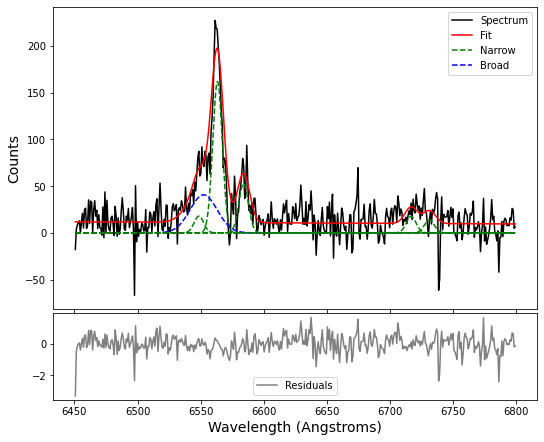

In [13]:
plot(wave1, spec1, err_spec1, pfit1)

In [14]:
# AGN 2 (Eastern)
wave2, spec2 = data_init(z,x,y2)

x02 = [900, 200, 70, 50, 0, 100, 200, 100, 600, 0, 10]
pfit2, perr2 = ltsq_mc_fitting(x02, wave2, spec2, err_spec2)
                                 
print(pfit2)
print(perr2)

# SII line amplitudes are 'saturated' in the fit -- have set them manually taking reference from 3x3 fit

[434.6917524   41.00775531  65.05891237  58.16637064 -22.672594
 135.65295791 161.59667046 -50.89155128 631.35773055 -33.97732898
 243.69743943]
[ 62.47578135  31.11049098  16.48748818  12.97396142  18.72712351
  36.56483398  38.63072592 153.98896875 111.08557479  13.49648938
  89.96411257]


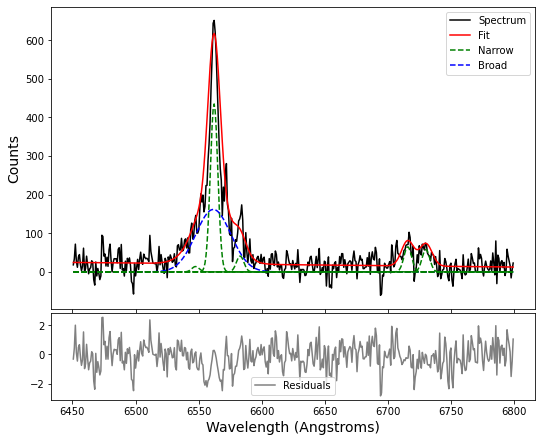

In [15]:
plot(wave2, spec2, err_spec2, pfit2)

In [16]:
agn1 = convolve(y1, Gaussian1DKernel(stddev=2))
agn2 = convolve(y2, Gaussian1DKernel(stddev=1.5))


/Users/orion/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later


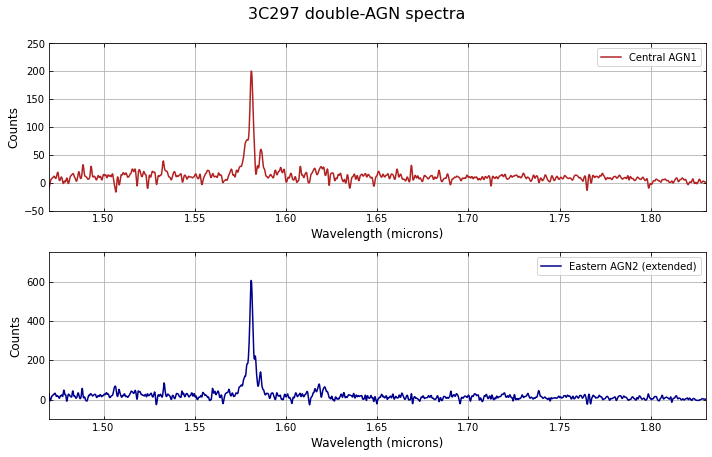

In [18]:
#fig, ax = plt.subplots(1,2)        #2 columns
fig, ax = plt.subplots(2,1)        #2 rows

ax[0].plot(x,agn1,linewidth=1.5,color='firebrick',label='Central AGN1')           #drawstyle='steps'
ax[1].plot(x,agn2,linewidth=1.5,color='darkblue',label='Eastern AGN2 (extended)')   #drawstyle='steps'
ax[0].tick_params(direction='in',top=True, right=True)
ax[1].tick_params(direction='in',top=True, right=True)
ax[0].set_ylabel('Counts', {'fontsize': 12})  
ax[1].set_ylabel('Counts', {'fontsize': 12})  
ax[0].set_xlabel('Wavelength (microns)', {'fontsize': 12}) 
ax[1].set_xlabel('Wavelength (microns)', {'fontsize': 12})  
ax[0].set_ylim(-50,250)
ax[1].set_ylim(-100,750)
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(200))
ax[0].set_xlim(1.47, 1.83)
ax[1].set_xlim(1.47, 1.83)
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend()
ax[1].legend()

fig.tight_layout()
my_suptitle = fig.suptitle('3C297 double-AGN spectra', x=0.5, y=1.05, fontsize=16)  
plt.rcParams["figure.figsize"] = [10,6]
#plt.rcParams["figure.figsize"] = [12,6]
fig.savefig('twinAGN_spec.png', dpi=200, facecolor='w', overwrite=True, bbox_inches='tight', 
            bbox_extra_artists=[my_suptitle])     # needs bbox=tight to include plot title in saved png